# Equivalent Layer technique for estimating magnetization direction of a magnetized source

#### Importing libraries

In [1]:
% matplotlib inline 

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pickle
import datetime
import timeit
from scipy.optimize import nnls
from fatiando.gridder import regular
from fatiando.utils import ang2vec, vec2ang
from fatiando.mesher import Sphere, PointGrid,Prism
from fatiando.gravmag import sphere,prism
from fatiando.constants import CM, T2NT, G, SI2MGAL

/home/andre/anaconda2/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


In [3]:
notebook_name = 'airborne_EQL_magdirection_RM.ipynb'

#### Importing auxiliary functions

In [4]:
dir_modules = '../../mypackage'
sys.path.append(dir_modules)

In [5]:
import auxiliary_functions as fc

#### Loading properties of the model

In [6]:
with open('data/model_sphere_remanent.pickle') as f:
        model_sphere_remanent = pickle.load(f)

#### Loading properties grid

In [7]:
with open('data/airborne_survey.pickle') as f:
        airborne = pickle.load(f)

#### Loading data

In [8]:
with open('data/data_set.pickle') as f:
        data = pickle.load(f)

#### Open a dictionary

In [9]:
dir_sphere = dict()

### Saving files

In [10]:
saved_files = []

## Observation area

In [11]:
print 'Area limits: \n x_max = %.1f m \n x_min = %.1f m \n y_max = %.1f m \n y_min = %.1f m' % (airborne['area'][1], 
                                                                                                airborne['area'][0],
                                                                                                airborne['area'][3],
                                                                                                airborne['area'][2])

Area limits: 
 x_max = 5000.0 m 
 x_min = -5000.0 m 
 y_max = 5000.0 m 
 y_min = -5000.0 m


### Airborne survey information

In [12]:
print 'Shape : (%.0f,%.0f)'% airborne['shape'] 
print 'Number of data: %.1f' % airborne['N']
print 'dx: %.1f m' % airborne['dx']
print 'dy: %.1f m ' % airborne['dy']

Shape : (50,20)
Number of data: 1000.0
dx: 204.1 m
dy: 526.3 m 


## Properties of the model

### Main field

In [13]:
inc_gf,dec_gf = model_sphere_remanent['main_field']

In [14]:
print'Main field inclination: %.1f degree' % inc_gf
print'Main field declination: %.1f degree' % dec_gf

Main field inclination: 40.0 degree
Main field declination: 45.0 degree


### Magnetization direction

In [15]:
print 'Intensity: %.1f A/m' % model_sphere_remanent['m']
print 'Inclination: %.1f degree' % model_sphere_remanent['inc']
print 'Declination: %.1f degree' % model_sphere_remanent['dec']

Intensity: 8.0 A/m
Inclination: 60.0 degree
Declination: 10.0 degree


In [16]:
inc_R,dec_R = model_sphere_remanent['inc'],model_sphere_remanent['dec']

## Generating the layer with my function 

In [17]:
h = 550.

#### Generating a layer

In [18]:
shape_layer = (airborne['shape'][0],airborne['shape'][1])

In [19]:
xs,ys,zs = regular(airborne['area'],shape_layer,h)

## Non-negative Least Squares Method for estimating a positive layer

In [20]:
G = fc.sensitivity_mag(airborne['x'],airborne['y'],airborne['z'],
                       xs,ys,zs,inc_gf,dec_gf,inc_R,dec_R)

In [21]:
start_time = timeit.default_timer()

In [22]:
m_pos,_ = nnls(G,data['tfa_obs_sphere_RM_airb'])

In [23]:
elapsed = timeit.default_timer() - start_time

In [24]:
print elapsed

2.18340802193


In [25]:
tf_pred_pos = fc.tfa_layer(airborne['x'],airborne['y'],airborne['z'],
                           xs,ys,zs,inc_gf,dec_gf,m_pos,inc_R,dec_R)

### Calculating residual

In [26]:
r_pos = data['tfa_obs_sphere_RM_airb'] - tf_pred_pos

#### Parameters for normalized histogram

In [27]:
r_norm,r_mean,r_std = fc.residual(data['tfa_obs_sphere_RM_airb'],tf_pred_pos)

In [28]:
print r_mean

-0.20213513730744345


## Comparison between the Model and the Layer with posivity

/home/andre/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/andre/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


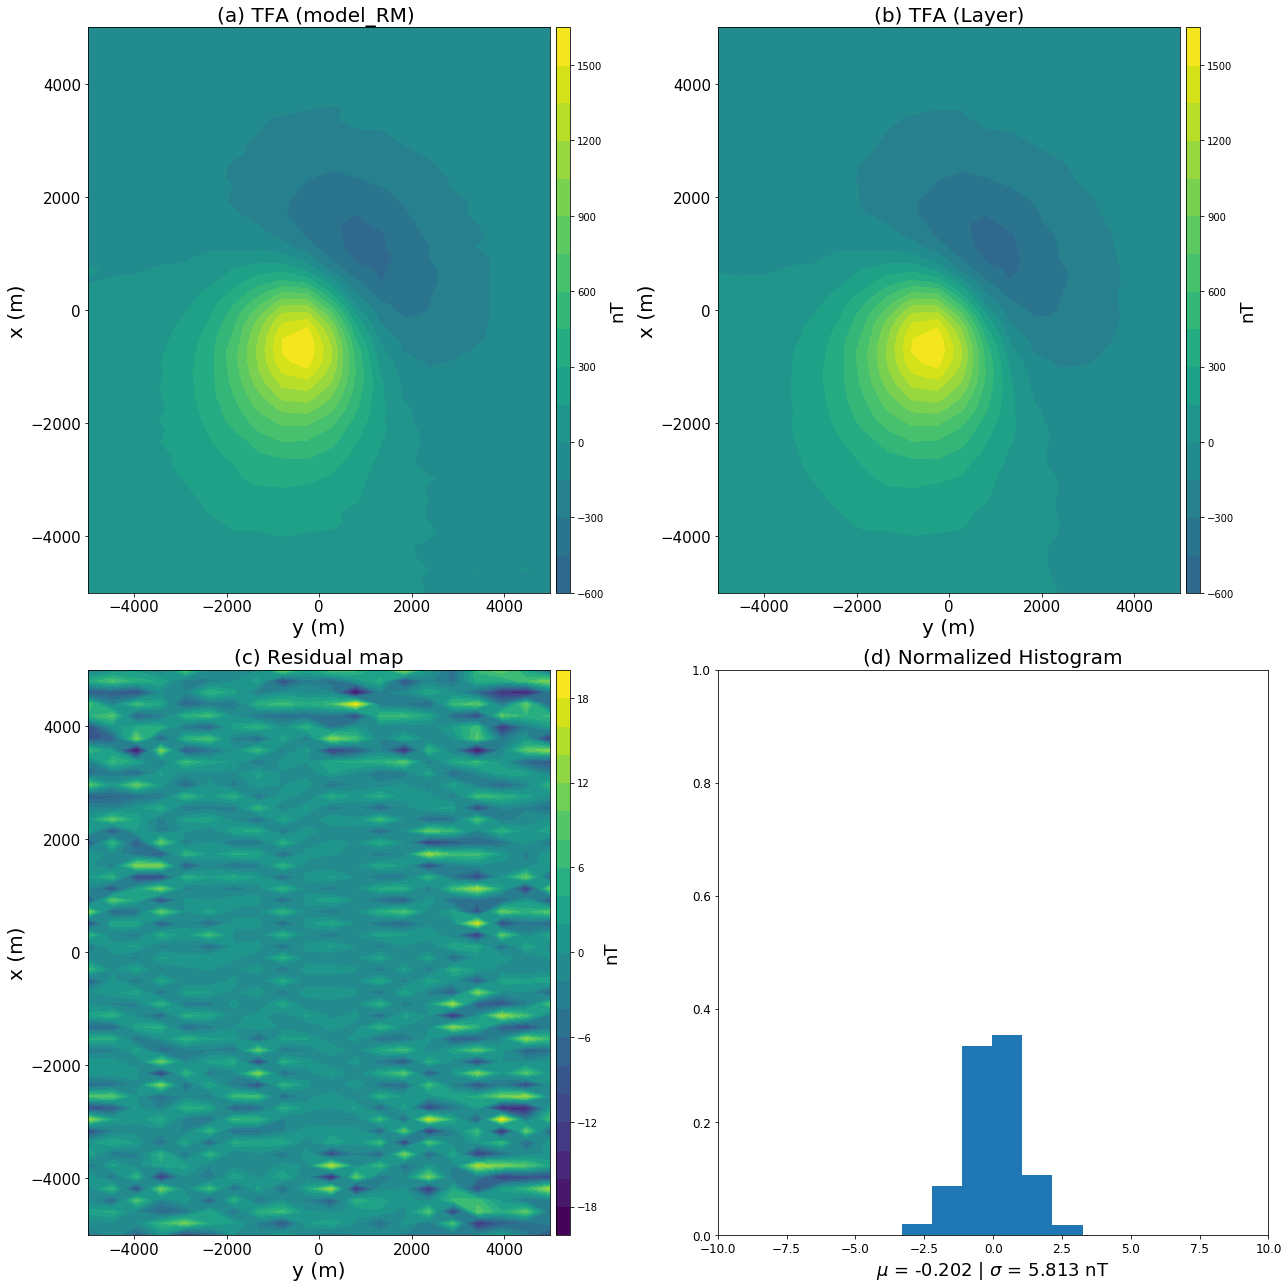

In [29]:
title_font = 20
bottom_font = 18
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(18,18), tight_layout=True)

ranges = saturation_factor*np.abs([data['tfa_obs_sphere_RM_airb'].max(), 
                                   data['tfa_obs_sphere_RM_airb'].min(),
                                   tf_pred_pos.max(), tf_pred_pos.min()]).max()

r_ranges = saturation_factor*np.abs([r_pos.max(), r_pos.min()]).max()


plt.subplot(2,2,1)
plt.contourf(airborne['y'].reshape(airborne['shape']),
             airborne['x'].reshape(airborne['shape']), 
             data['tfa_obs_sphere_RM_airb'].reshape(airborne['shape']),
             20, cmap='viridis',vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT',size=bottom_font) 
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('(a) TFA (model_RM) ', fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(2,2,2)
plt.contourf(airborne['y'].reshape(airborne['shape']),
             airborne['x'].reshape(airborne['shape']),
             tf_pred_pos.reshape(airborne['shape']),
             20, cmap='viridis',  vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT',size=bottom_font)
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('(b) TFA (Layer)', fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(2,2,3)
plt.contourf(airborne['y'].reshape(airborne['shape']),
             airborne['x'].reshape(airborne['shape']),
             r_pos.reshape(airborne['shape']), 
             20, cmap='viridis',  vmin=-r_ranges, vmax=r_ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT',size=bottom_font)
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('(c) Residual map', fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=15)


plt.subplot(2,2,4)
plt.xlabel('$\mu$ = %.3f | $\sigma$ = %.3f nT' % (r_mean, r_std),
           fontsize = bottom_font)
nbins = int((np.max(r_norm - np.min(r_norm))))
plt.hist(r_norm,bins=nbins,normed=True)
plt.ylim(0.,1.)
plt.xlim(-10., 10.)
plt.title('(d) Normalized Histogram',fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=12)

file_name = 'figs/airborne/noisy_data_fitting_NNLS_magRM'
plt.savefig(file_name+'.png',dpi=300)
saved_files.append(file_name+'.png')

plt.savefig(file_name+'.eps',dpi=300)
saved_files.append(file_name+'.eps')

plt.show()

### Magnetic moment within the Layer with positivity constraint

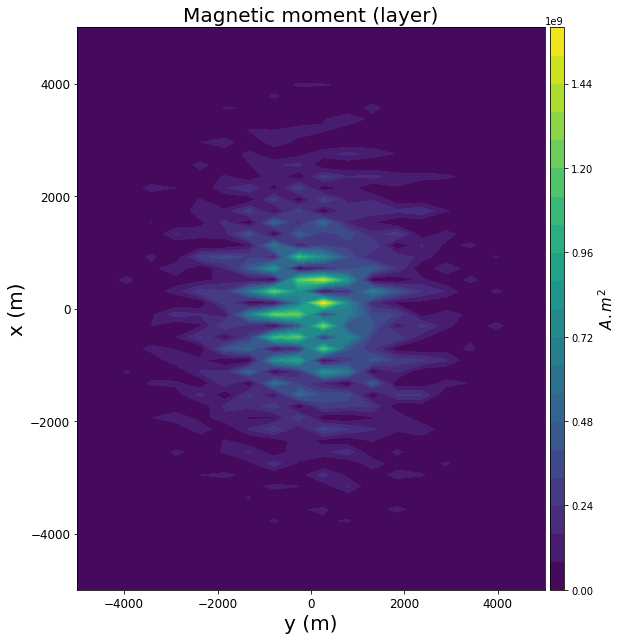

In [30]:
title_font = 20
bottom_font = 18
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(9,9), tight_layout=True)

plt.contourf(ys.reshape(shape_layer),xs.reshape(shape_layer), 
             m_pos.reshape(shape_layer),20, cmap='viridis')
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('$A.m^2$',size=15)
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('Magnetic moment (layer)', fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=12)

file_name = 'figs/airborne/noisy_magnetic_moment_positive_NNLS_magIM'
plt.savefig(file_name+'.png',dpi=300)
saved_files.append(file_name+'.png')

plt.savefig(file_name+'.eps',dpi=300)
saved_files.append(file_name+'.eps')

plt.show()

### Levenberg-Marquardt with NNLS for positive magnetic moments

In [31]:
i_pos = 1500

In [32]:
it_max = 30

In [33]:
it_marq = 15

In [34]:
lamb = 10.
dlamb = 100.

In [35]:
eps_e = 1e-4
eps_i = 1e-4

In [36]:
m_LM,inc_est,dec_est,phi,imax,pest,incs,decs = fc.levenberg_marquardt_NNLS(
    data['tfa_obs_sphere_RM_airb'],airborne['x'],airborne['y'],
    airborne['z'],xs,ys,zs,inc_gf,dec_gf,20.,20.,lamb,dlamb,i_pos,it_max,
    it_marq,eps_e,eps_i)

i = 0
1.4085329002366239e-05
21.71801913117346 20.385047123925904
0.1328514464525864
i = 1
1.0174008520447919e-05
23.18212343685207 20.751629975325088
0.11318821819962006
i = 2
7.589540527144448e-06
24.45648515378637 21.099364847292865
0.09888439572728995
i = 3
5.748855426563148e-06
25.57899304994039 21.431192902183565
0.08726657245970351
i = 4
4.454980058108376e-06
26.579362067233323 21.750227639912914
0.07795726752158955
i = 5
3.512173380542744e-06
27.47940635703931 22.057369910030474
0.07029980036453849
i = 6
2.811871332359701e-06
28.2957785626812 22.35359390870208
0.06390089514480339
i = 7
2.2772884488777356e-06
29.0409874698416 22.639656355043666
0.0584075905036455
i = 8
1.8618624129321372e-06
29.725473974374268 22.915092631259476
0.05368324218672064
i = 9
1.5380940325157328e-06
30.357527290999087 23.18062707949325
0.04958147261210533
i = 10
1.2825855356310746e-06
30.94388958191071 23.436916574253683
0.0459876914516903
i = 11
1.077953335863219e-06
31.49001702965327 23.684576257308

1.2584743444084289e-09
44.93512423936572 32.44179591815987
0.002338326005795819
i = 96
1.1999251009338353e-09
44.99564825284987 32.48763139306863
0.0022888850493356827
i = 97
1.1444351537117593e-09
45.055455528382865 32.53283967983475
0.002240822227977241
i = 98
1.0914034467118905e-09
45.11456168086866 32.57741671558858
0.0021939221466472283
i = 99
1.041082152085909e-09
45.17298193828327 32.62137056825895
0.002148299607404138
i = 100
9.93399845641929e-10
45.23073120833603 32.66471177765155
0.0021039527305382025
i = 101
9.482024933613585e-10
45.28782394229481 32.70745062512299
0.0020608377286706245
i = 102
9.053480012107219e-10
45.344274213967175 32.749597267880226
0.002018917896479377
i = 103
8.647407484378946e-10
45.400095995120694 32.79116256354113
0.0019781834730755793
i = 104
8.265635216001067e-10
45.45530562285268 32.832165119074766
0.0019388564946692104
i = 105
7.903028461517981e-10
45.50991573021904 32.87261394683911
0.001900584160258451
i = 106
7.560132298691163e-10
45.56394064

3.7032016063553463e-11
48.716319656846295 34.851488968899076
0.0005287256206936151
i = 189
3.592228648598438e-11
48.7446383985687 34.86325804944124
0.0005225495292293311
i = 190
3.485035915647891e-11
48.77279663714494 34.87481782276012
0.0005164794821471624
i = 191
3.3817278716924195e-11
48.80079624053172 34.886170412318336
0.0005105162854149555
i = 192
3.2819355971389554e-11
48.82863901799907 34.8973178576341
0.0005046565223184924
i = 193
3.185270678838974e-11
48.856326528121876 34.908261704732
0.000498889044429788
i = 194
3.0917644079694514e-11
48.88386034138235 34.91900270445851
0.000493211383583634
i = 195
3.0013951592616936e-11
48.91124221058756 34.929542890348316
0.0004876323256676812
i = 196
2.9143169272983796e-11
48.93847385894113 34.93988426767357
0.0004821497423737233
i = 197
2.8283052294718554e-11
48.96555582383233 34.95002029975273
0.0004767016868328463
i = 198
2.744918524231863e-11
48.99248971212166 34.95995055591247
0.0004713398328638833
i = 199
2.664503173643185e-11
49.0

4.992918500832492e-12
50.82117778439421 35.225753656569545
0.00023294937763559072
i = 281
4.939395878566807e-12
50.83998905461383 35.22385364626961
0.000231478999126844
i = 282
4.886925595040036e-12
50.858736060345954 35.2218576102644
0.00023002751356456126
i = 283
4.835509795141042e-12
50.8774192877314 35.21976632976957
0.00022859402242245513
i = 284
4.785896155446171e-12
50.896039444330775 35.21758024907867
0.00022718411439440637
i = 285
4.737714881786934e-12
50.91459708381765 35.21529988084918
0.0002257938013938324
i = 286
4.6917147246546e-12
50.93309264175008 35.21292575205148
0.0002244200614061914
i = 287
4.6460328797661426e-12
50.95152656434842 35.210458577306056
0.0002230627974598487
i = 288
4.602537483978466e-12
50.96989920749539 35.20789913322886
0.00022171962359642056
i = 289
4.558990399508349e-12
50.9882109569938 35.20524816245973
0.00022039116771357194
i = 290
4.518382167964895e-12
51.00646224461577 35.20250636087624
0.00021907845177234736
i = 291
4.477351853892998e-12
51.0

3.1318914329400226e-12
52.32994126810904 34.72422354352724
0.00014761900618813744
i = 373
3.1251140744640004e-12
52.344288537972716 34.71587455821447
0.00014704093459328056
i = 374
3.1171736513632028e-12
52.35859880142109 34.70747724179666
0.00014646762015097333
i = 375
3.1117284731945237e-12
52.372872245101256 34.699031967716955
0.00014589899999401453
i = 376
3.1056983911187507e-12
52.3871090540242 34.690539107046064
0.00014533501220464064
i = 377
3.0994684024470145e-12
52.40130982008143 34.68199822094045
0.0001447854446945908
i = 378
3.0930384097954464e-12
52.41547476988884 34.673409585184096
0.000144241455607984
i = 379
3.087758025431881e-12
52.429604266344455 34.66477323834124
0.00014370619760619173
i = 380
3.0811209720795967e-12
52.44369851055394 34.656089499132854
0.00014317584120280012
i = 381
3.0760200327532742e-12
52.457757679483905 34.64735872392781
0.00014264979780202747
i = 382
3.0712986818684022e-12
52.4717819485735 34.638581266876194
0.00014212801083682134
i = 383
3.06676

2.6527734680849395e-12
53.51614966504831 33.78856918882454
0.00010911328479930309
i = 465
2.64724416041588e-12
53.527711380422126 33.77690559018434
0.0001087953642686237
i = 466
2.6405284087122444e-12
53.53924761066796 33.765217605138574
0.00010847912467767021
i = 467
2.634990451363079e-12
53.550758456528676 33.75350547291502
0.00010816454632963441
i = 468
2.629251200490703e-12
53.56224401804411 33.74176943148249
0.00010785160979903257
i = 469
2.6240992184309093e-12
53.57370441630803 33.730009571679325
0.00010754112123345301
i = 470
2.6179572421456607e-12
53.58513982880977 33.71822559916279
0.00010723523135000657
i = 471
2.611810917627633e-12
53.596550353469745 33.70641774860634
0.00010693092444902174
i = 472
2.6064494392618646e-12
53.607936093604756 33.69458624279721
0.00010662831054172708
i = 473
2.6012813254499115e-12
53.61929718694652 33.68273124164863
0.00010632811272656547
i = 474
2.595911964158493e-12
53.63063372923402 33.670852976287044
0.00010602943812524241
i = 475
2.59053866

### Visualization of the convergence

In [37]:
phi = (np.array(phi)/airborne['x'].size)

<Figure size 648x648 with 0 Axes>

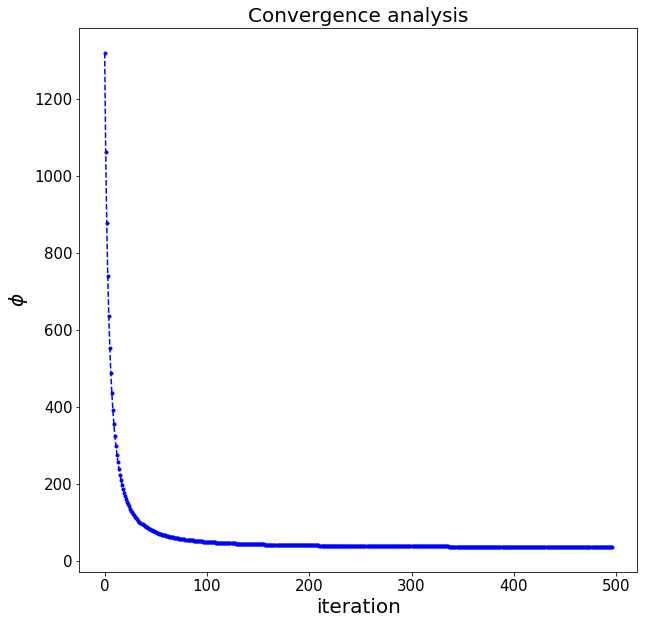

In [38]:
title_font = 20
bottom_font = 18
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(9,9), tight_layout=True)

plt.figure(figsize=(10, 10))
plt.plot(phi, 'b--')
plt.plot(phi, 'b.')

plt.title('Convergence analysis', fontsize=title_font)
plt.xlabel('iteration', fontsize = title_font)
plt.ylabel('$\phi$', fontsize = title_font)
plt.tick_params(axis='both', which='major', labelsize=15)

file_name = 'figs/airborne/convergence_LM_NNLS_magRM'
plt.savefig(file_name+'.png',dpi=300)
saved_files.append(file_name+'.png')

plt.savefig(file_name+'.eps',dpi=300)
saved_files.append(file_name+'.eps')


plt.show()

### Estimated magnetization direction

In [39]:
print (inc_est,dec_est)

(53.86320637240191, 33.41631614639864)


In [40]:
print (inc_R,dec_R)

(60.0, 10.0)


### Comparison between observed data and predicted data

In [41]:
pred = fc.tfa_layer(airborne['x'],airborne['y'],airborne['z'],
                    xs,ys,zs,inc_gf,dec_gf,m_LM,inc_est,dec_est)

In [42]:
res = pred - data['tfa_obs_sphere_RM_airb']

In [43]:
r_norm,r_mean,r_std = fc.residual(data['tfa_obs_sphere_RM_airb'],pred)

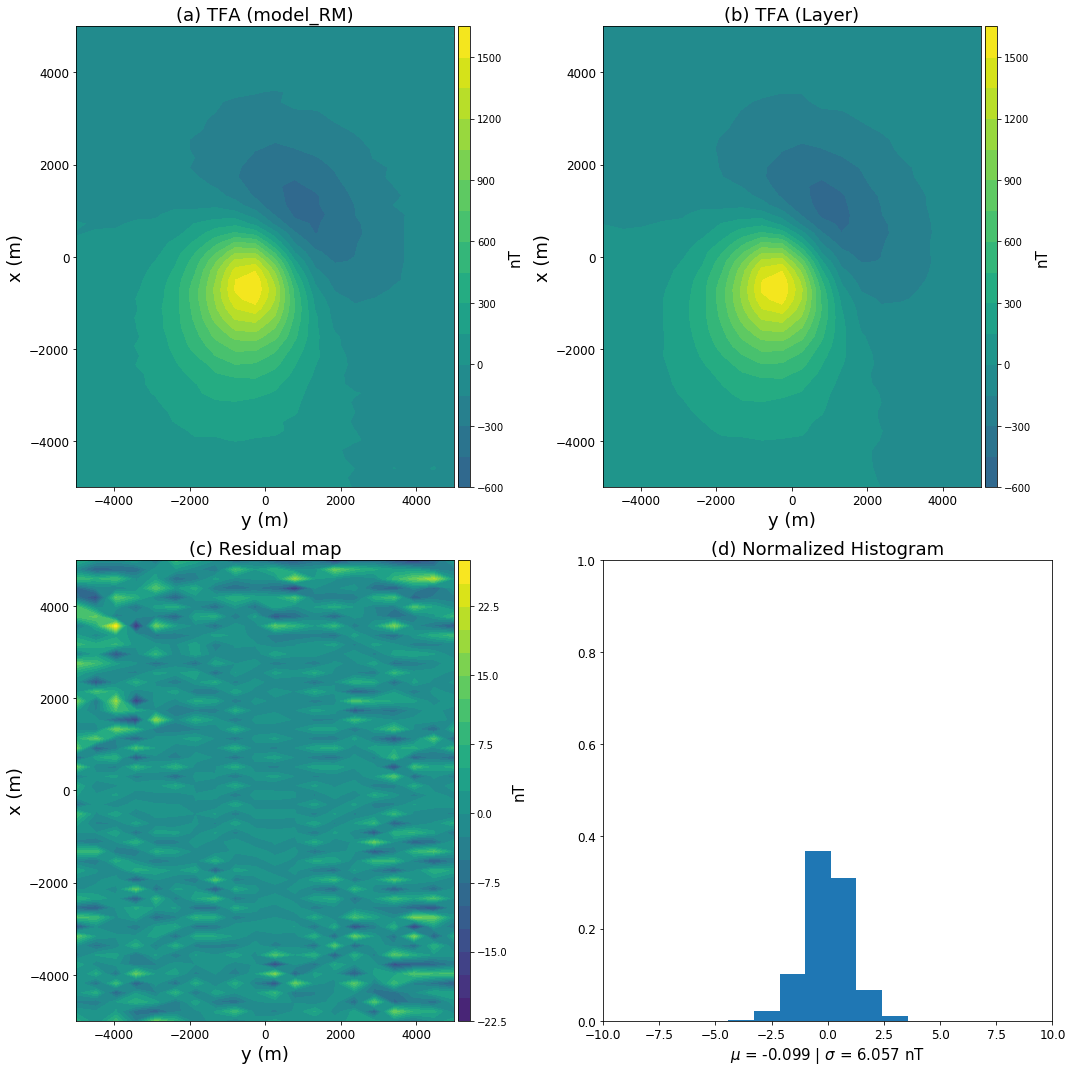

In [44]:
title_font = 18
bottom_font = 15
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(15,15), tight_layout=True)

ranges = saturation_factor*np.abs([data['tfa_obs_sphere_RM_airb'].max(), 
                                   data['tfa_obs_sphere_RM_airb'].min(),
                                   pred.max(), pred.min()]).max()
res_ranges = np.max(np.abs(res))

plt.subplot(2,2,1)
plt.contourf(airborne['y'].reshape(airborne['shape']),
             airborne['x'].reshape(airborne['shape']), 
             data['tfa_obs_sphere_RM_airb'].reshape(airborne['shape']),
             20, cmap='viridis',vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT',size=bottom_font)
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('(a) TFA (model_RM)',fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.subplot(2,2,2)
plt.contourf(airborne['y'].reshape(airborne['shape']),
             airborne['x'].reshape(airborne['shape']),
             pred.reshape(airborne['shape']),
             20, cmap='viridis',  vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT',size=bottom_font)
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('(b) TFA (Layer)', fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.subplot(2,2,3)
plt.contourf(airborne['y'].reshape(airborne['shape']),
             airborne['x'].reshape(airborne['shape']),
             res.reshape(airborne['shape']), 
             20, cmap='viridis',  vmin=-res_ranges, vmax=res_ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT',size=bottom_font)
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('(c) Residual map', fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=12)


plt.subplot(2,2,4)
plt.xlabel('$\mu$ = %.3f | $\sigma$ = %.3f nT' % (r_mean, r_std),
           fontsize = bottom_font)
nbins = int((np.max(r_norm - np.min(r_norm))))
plt.hist(r_norm,bins=nbins,normed=True)
plt.ylim(0.,1.)
plt.xlim(-10., 10.)
plt.title('(d) Normalized Histogram',fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=12)

file_name = 'figs/airborne/data_fitting_LM_NNLS_magRM'
plt.savefig(file_name+'.png',dpi=300)
saved_files.append(file_name+'.png')

plt.savefig(file_name+'.eps',dpi=300)
saved_files.append(file_name+'.eps')


plt.show()

### Estimated magnetic moment within the layer

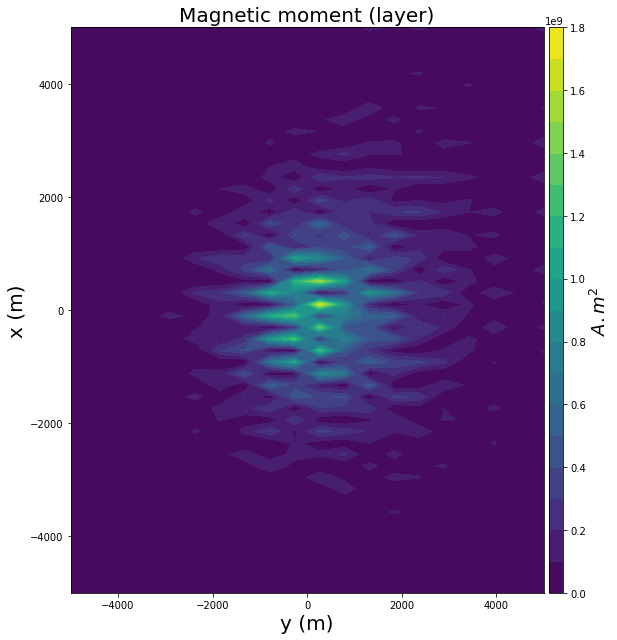

In [45]:
title_font = 20
bottom_font = 18
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(9,9), tight_layout=True)

plt.contourf(ys.reshape(shape_layer),xs.reshape(shape_layer), 
             m_LM.reshape(shape_layer), 20, cmap='viridis')
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('$A.m^2$',size=bottom_font)
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('Magnetic moment (layer)', fontsize=title_font)

file_name = 'figs/airborne/magnetic_moment_positive_LM_NNLS_magRM'
plt.savefig(file_name+'.png',dpi=300)
saved_files.append(file_name+'.png')

plt.savefig(file_name+'.eps',dpi=300)
saved_files.append(file_name+'.eps')


plt.show()

### Reduction to the pole

In [46]:
G_rtp = fc.sensitivity_mag(airborne['x'],airborne['y'],airborne['z'],
                       xs,ys,zs,90.,0.,90.,0.)

In [47]:
tfa_rtp = np.dot(G_rtp,m_LM)

#### Visualization of a reduction to the pole

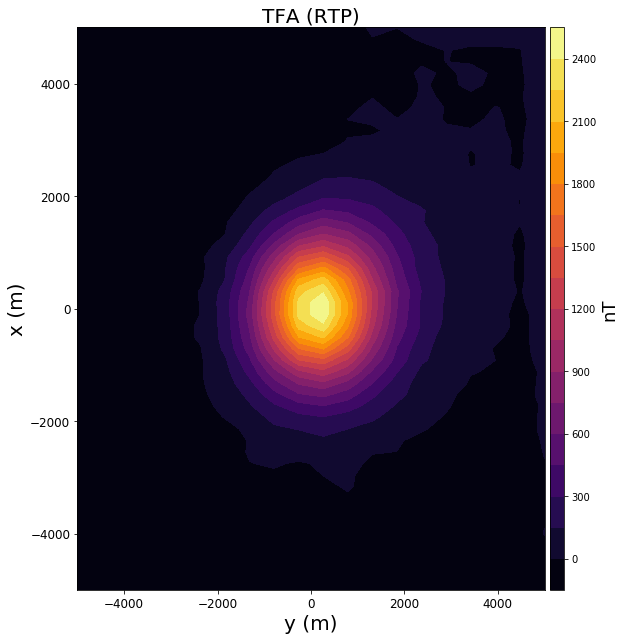

In [48]:
title_font = 20
bottom_font = 18
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(9,9), tight_layout=True)

plt.contourf(airborne['y'].reshape(airborne['shape']), 
             airborne['x'].reshape(airborne['shape']),
             tfa_rtp.reshape(airborne['shape']), 
             20, cmap='inferno')
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT',size=bottom_font)
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('TFA (RTP)', fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=12)

file_name = 'figs/airborne/RTP_airborne_magRM'
plt.savefig(file_name+'.png',dpi=300)
saved_files.append(file_name+'.png')

plt.savefig(file_name+'.eps',dpi=300)
saved_files.append(file_name+'.eps')

plt.show()

# Visualization of the RTP and Magnetic moment over the layer

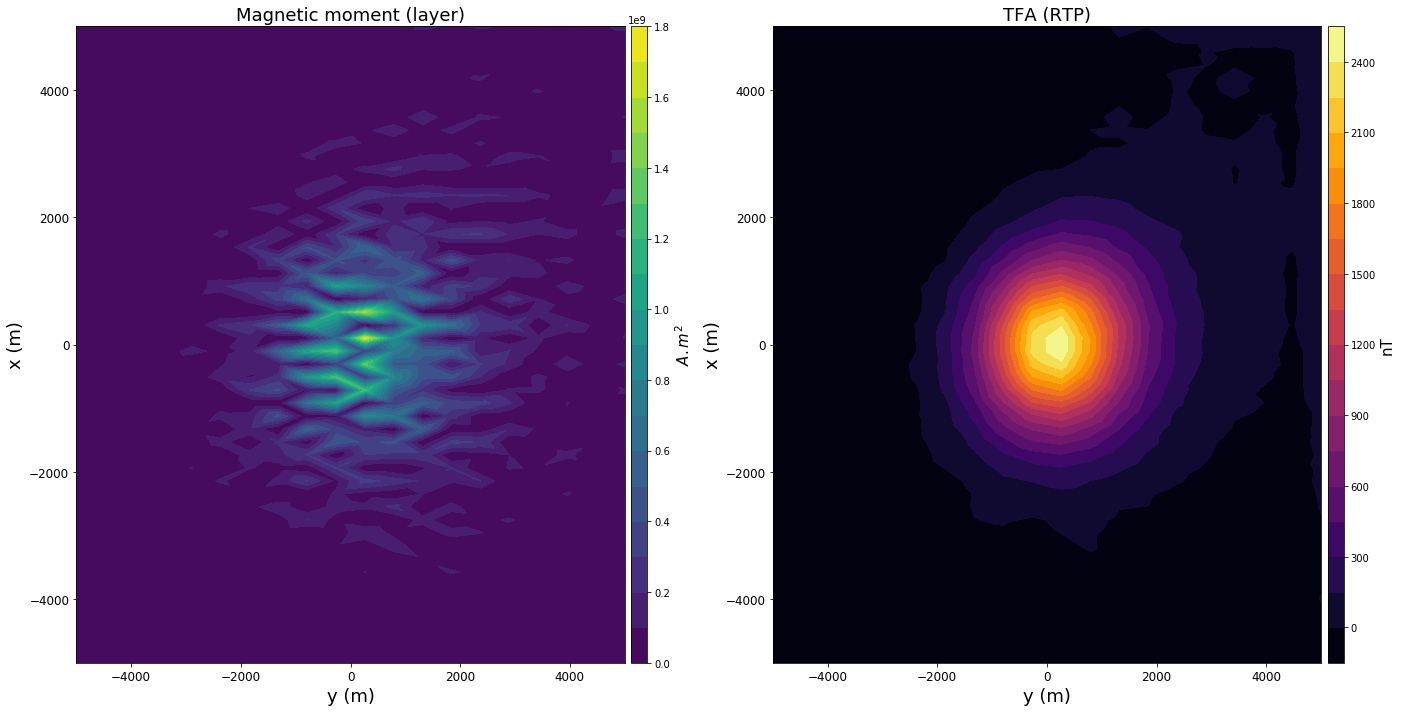

In [49]:
title_font = 18
bottom_font = 15
plt.close('all')
plt.figure(figsize=(20,10), tight_layout=True)

plt.subplot(1,2,1)
plt.tricontourf(ys,xs,m_LM,20,cmap='viridis')
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('$A.m^2$',size=bottom_font)
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('Magnetic moment (layer)', fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.subplot(1,2,2)
plt.tricontourf(airborne['y'],airborne['x'], tfa_rtp, 20, cmap='inferno')
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT',size=bottom_font)
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('TFA (RTP)', fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=12)

file_name = 'figs/airborne/RTP_moment_LM_NNLS_RM'
plt.savefig(file_name+'.png',dpi=300)
saved_files.append(file_name+'.png')

plt.savefig(file_name+'.eps',dpi=300)
saved_files.append(file_name+'.eps')

plt.show()